## Settings

In [52]:
setwd("~/git/hist_future_hail/")                             # Working directory.
source("modules/gev_functions.R")                            # Load helper functions.
variables = c("hailcast_diam_max", "wind_10m")               # Variables to process.
results_dir = "/g/data/up6/tr2908/hist_future_hail/results/" # Results directory.
set.seed(42)                                                 # Random seed for reproducibility.

## Read in data

In [3]:
all_dat = read_feathers(results_dir = results_dir)

[1] "/g/data/up6/tr2908/hist_future_hail/results//Brisbane_hist_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Brisbane_ssp245_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Melbourne_hist_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Melbourne_ssp245_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Perth_hist_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Perth_ssp245_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Sydney_Canberra_hist_block_maxima.feather"
[1] "/g/data/up6/tr2908/hist_future_hail/results//Sydney_Canberra_ssp245_block_maxima.feather"


## Timeseries of maxima

First the timeseries of daily hail diameter maxima.

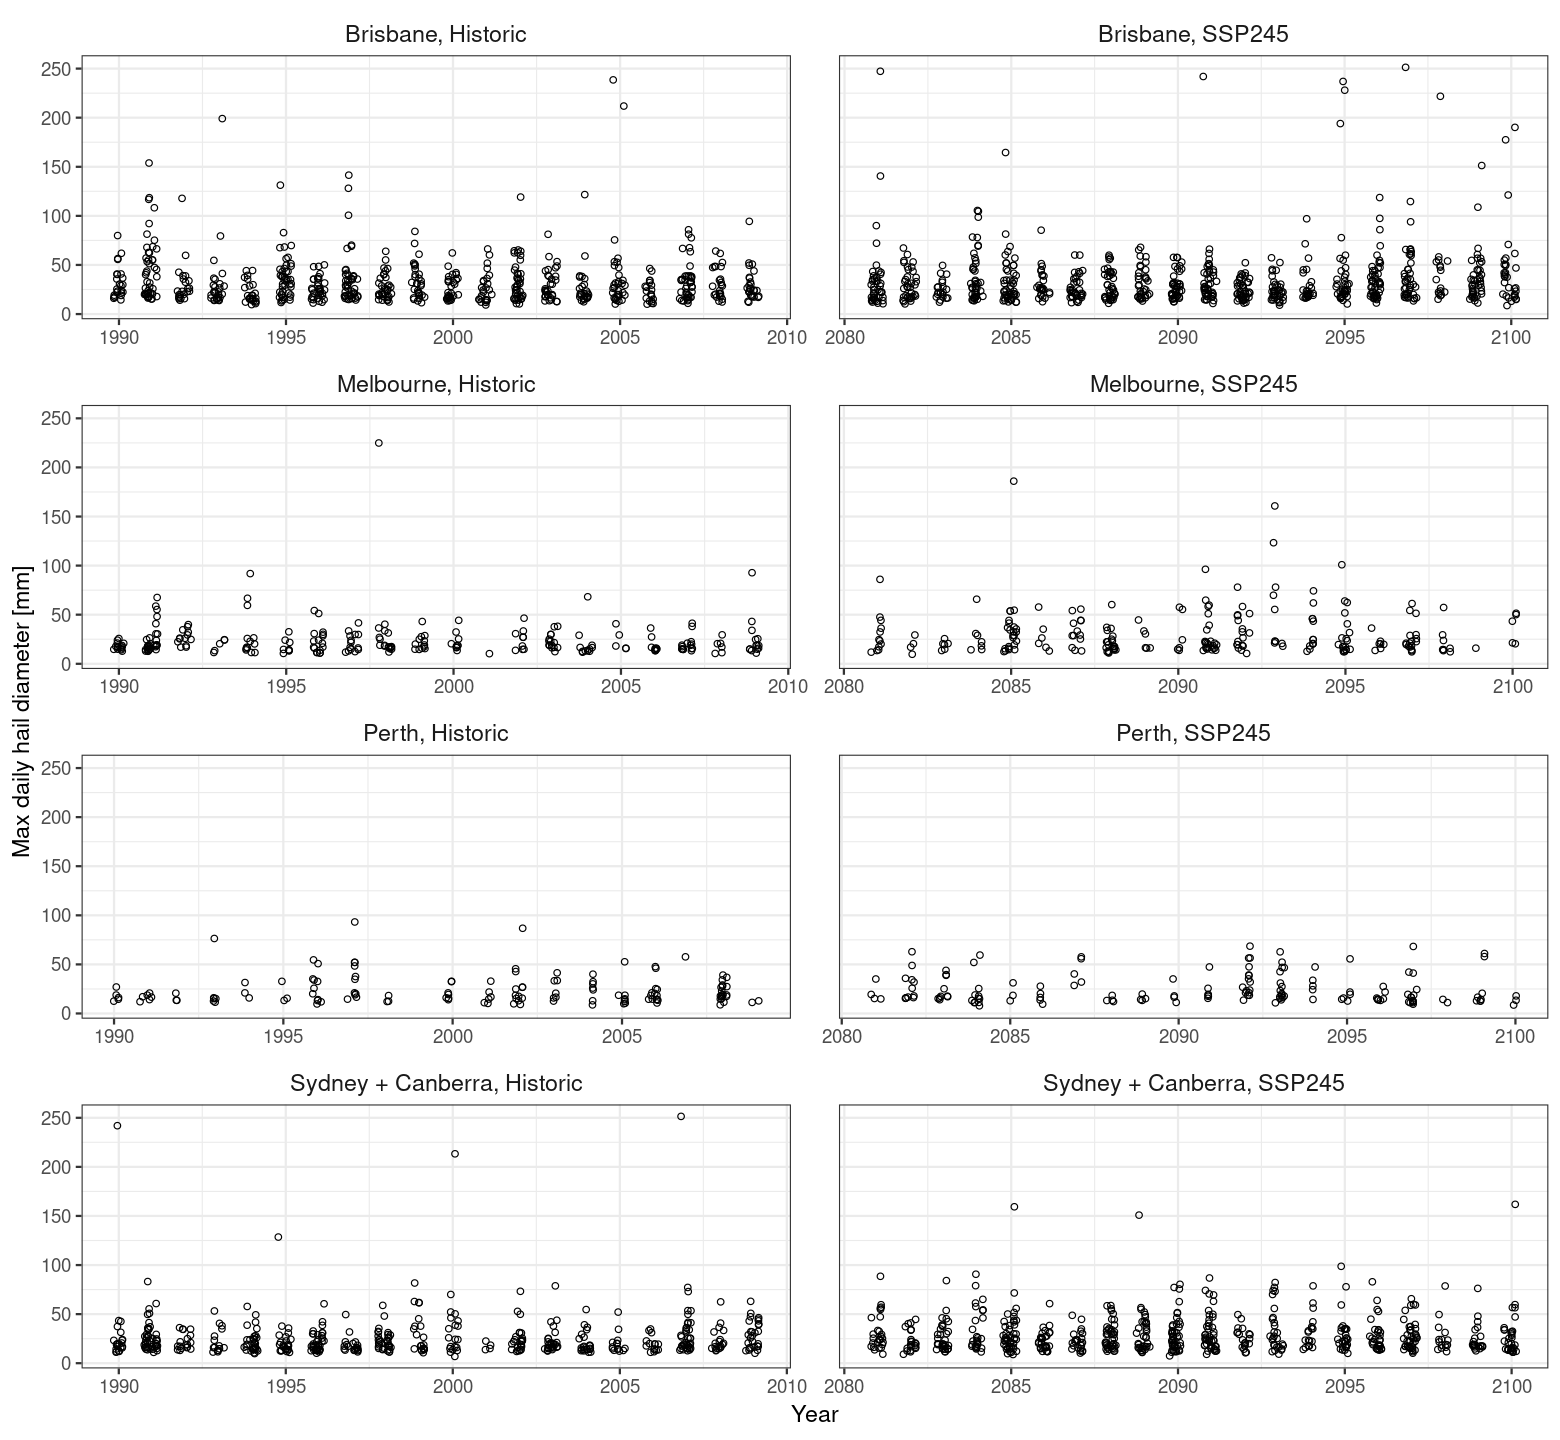

In [4]:
options(repr.plot.width = 13, repr.plot.height = 12)
plot_ts(dat = all_dat, ylabel = "Max daily hail diameter [mm]", var = "hailcast_diam_max")

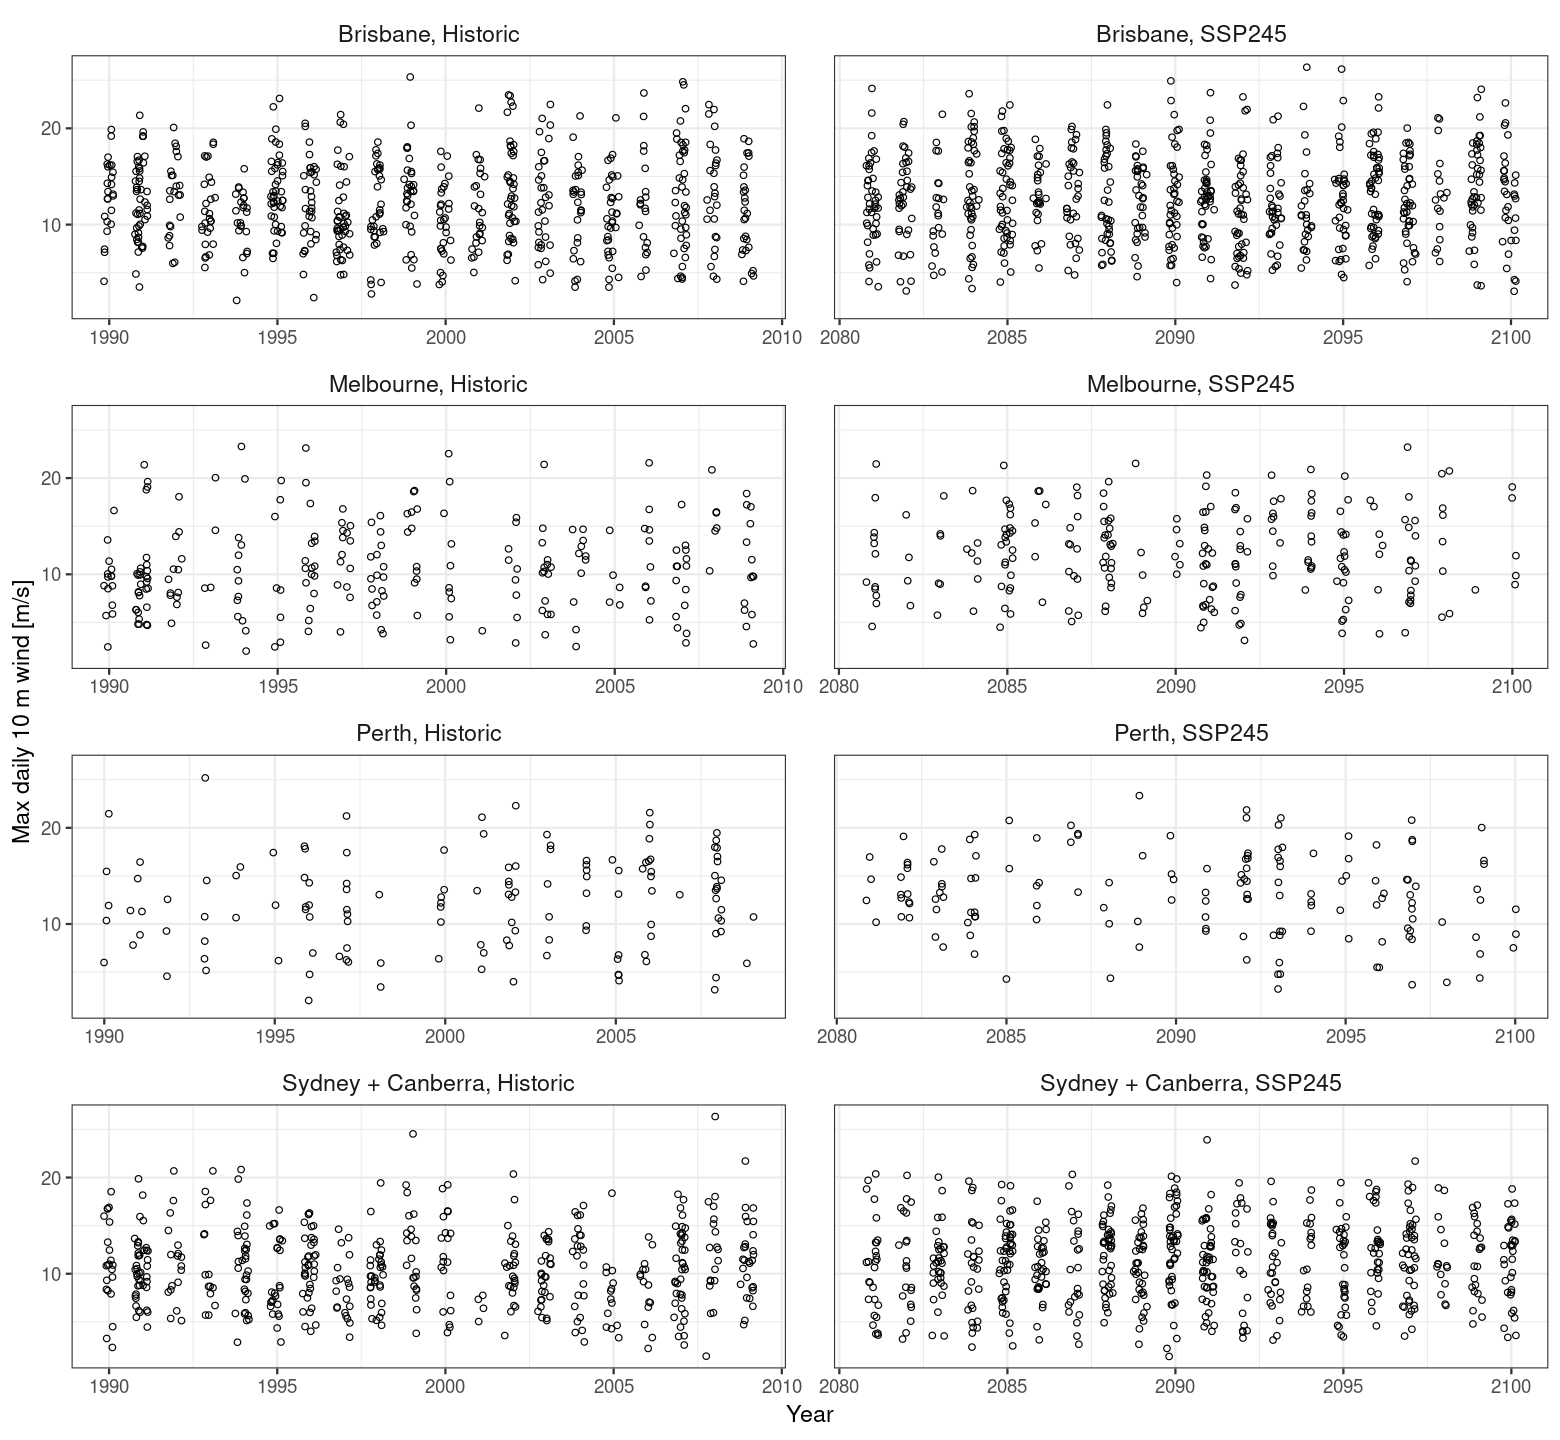

In [5]:
plot_ts(dat = all_dat, ylabel = "Max daily 10 m wind [m/s]", var = "wind_10m")

## GEV fitting

In [6]:
source("modules/gev_functions.R")
gev_fits = fit_gevs(all_dat = all_dat)

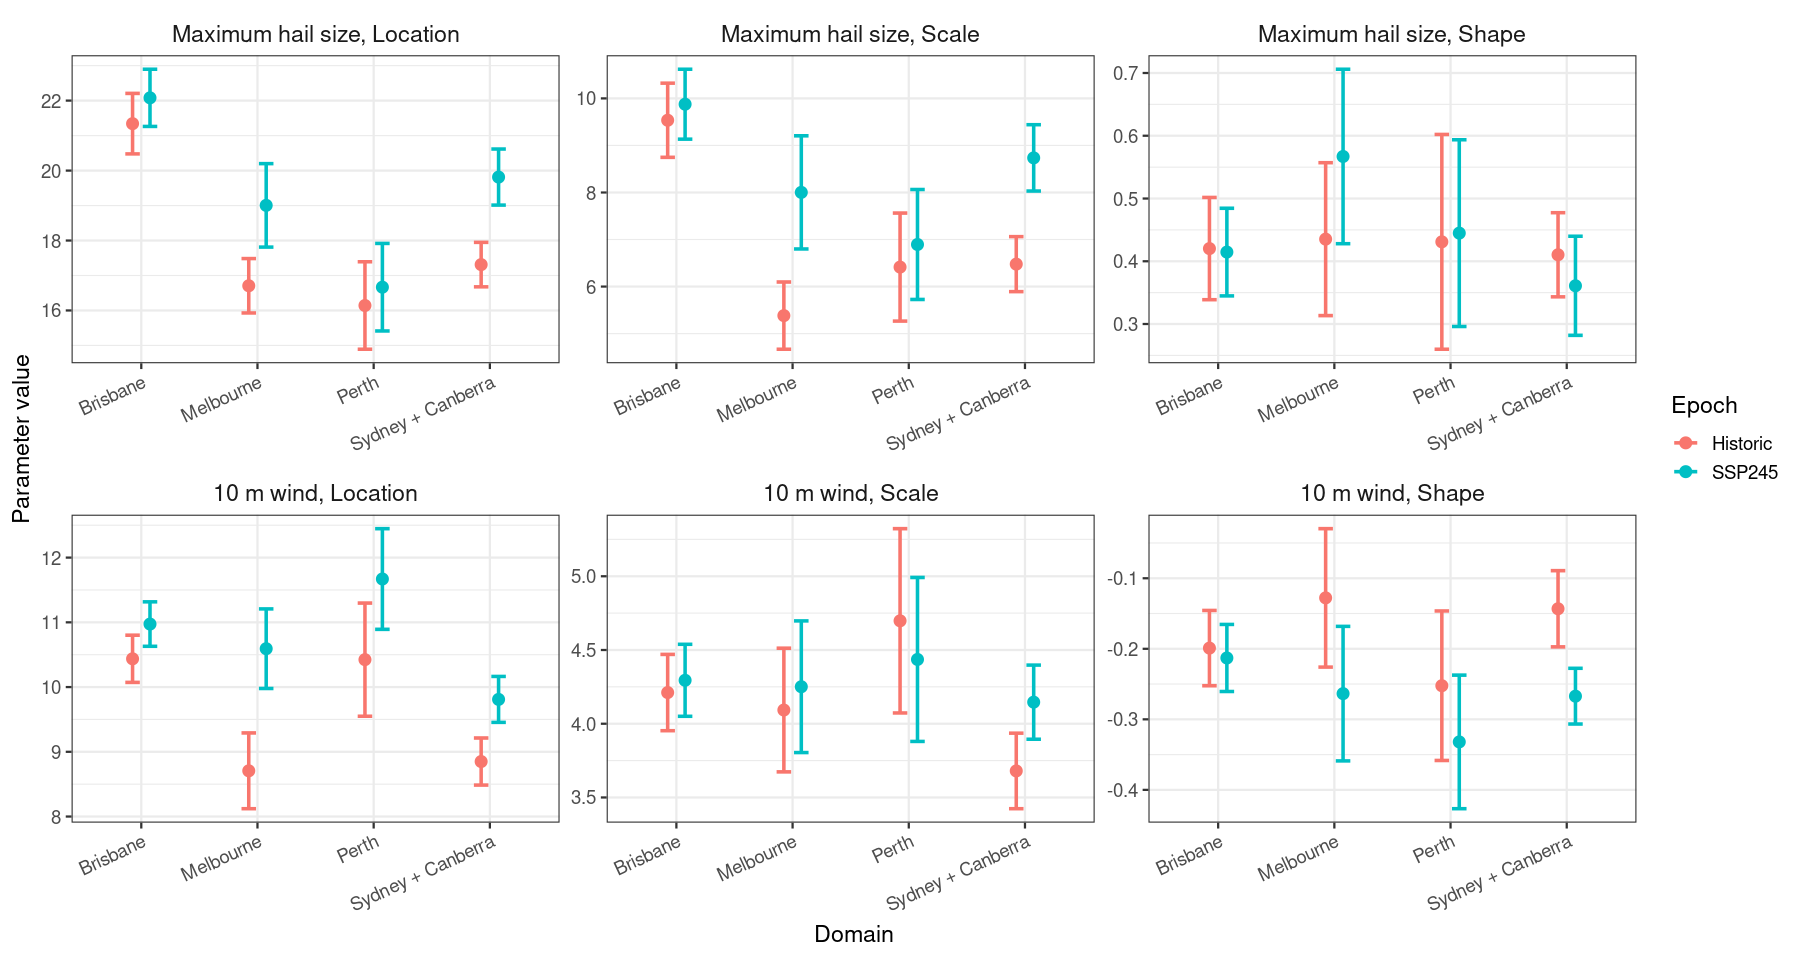

In [7]:
options(repr.plot.width = 15, repr.plot.height = 8)
plot_params(gev_fits = gev_fits, file = "paper/figures/fit_params.pdf")

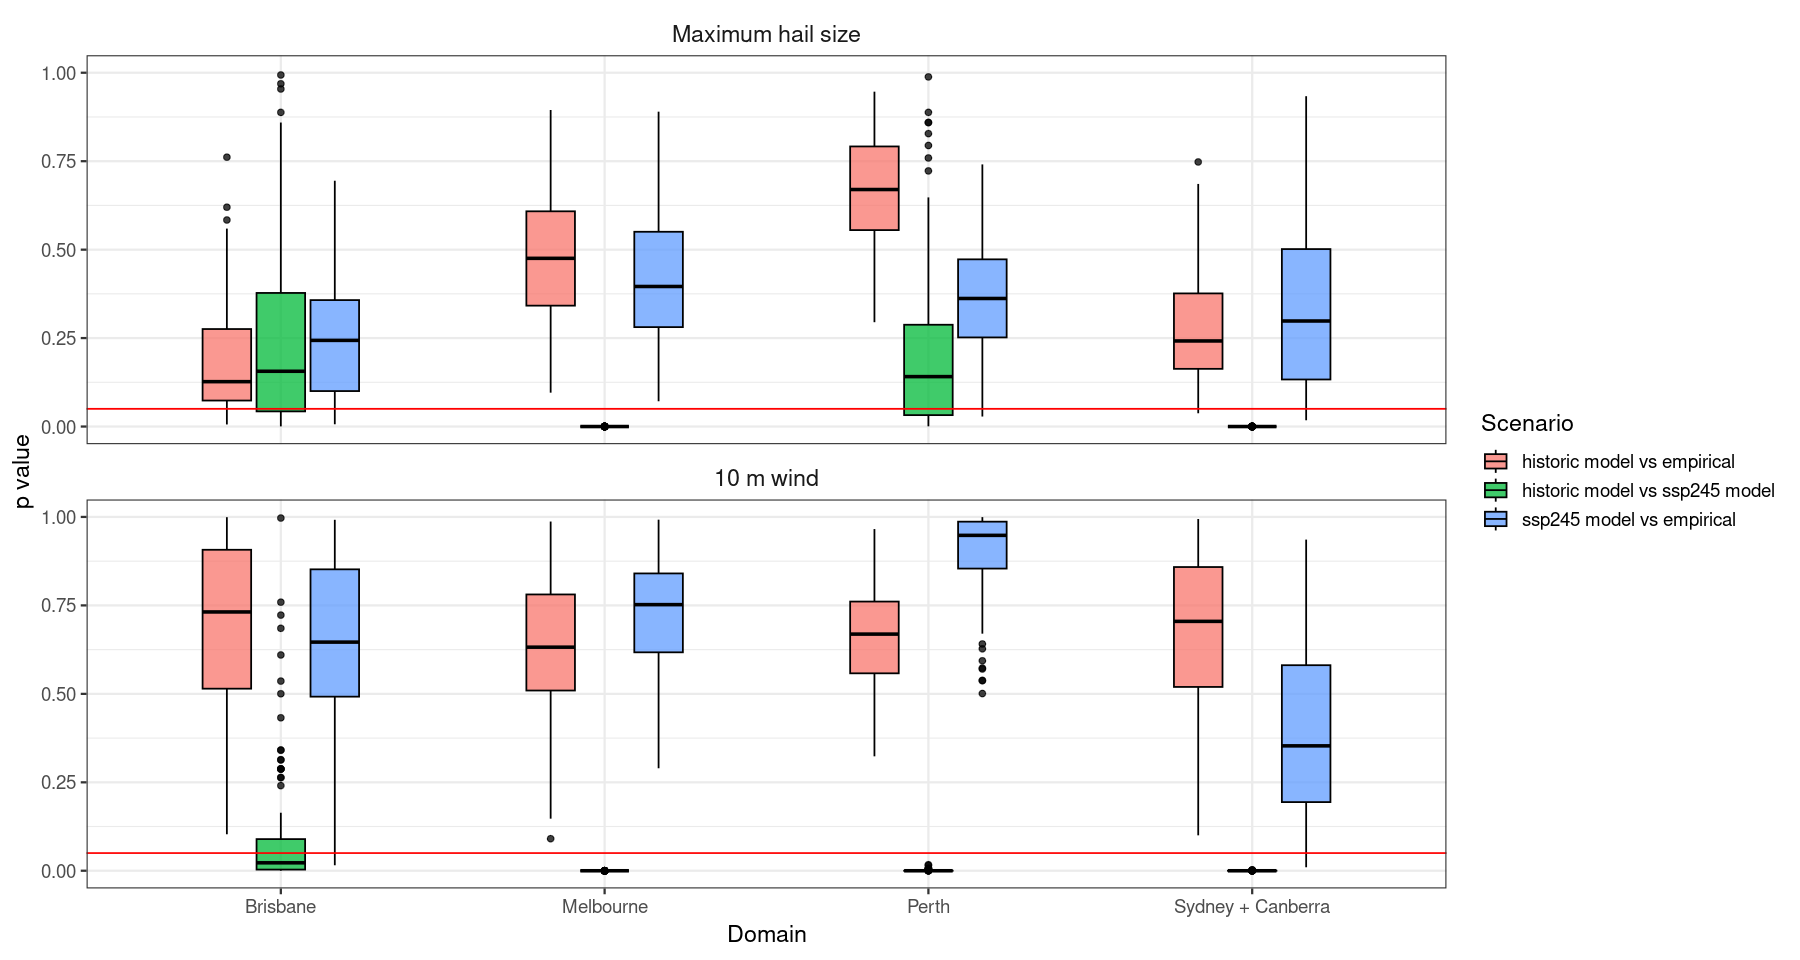

In [8]:
options(repr.plot.width = 15, repr.plot.height = 8)
plot_ks_fits(gev_fits = gev_fits, file = "paper/figures/fit_pvals.pdf")

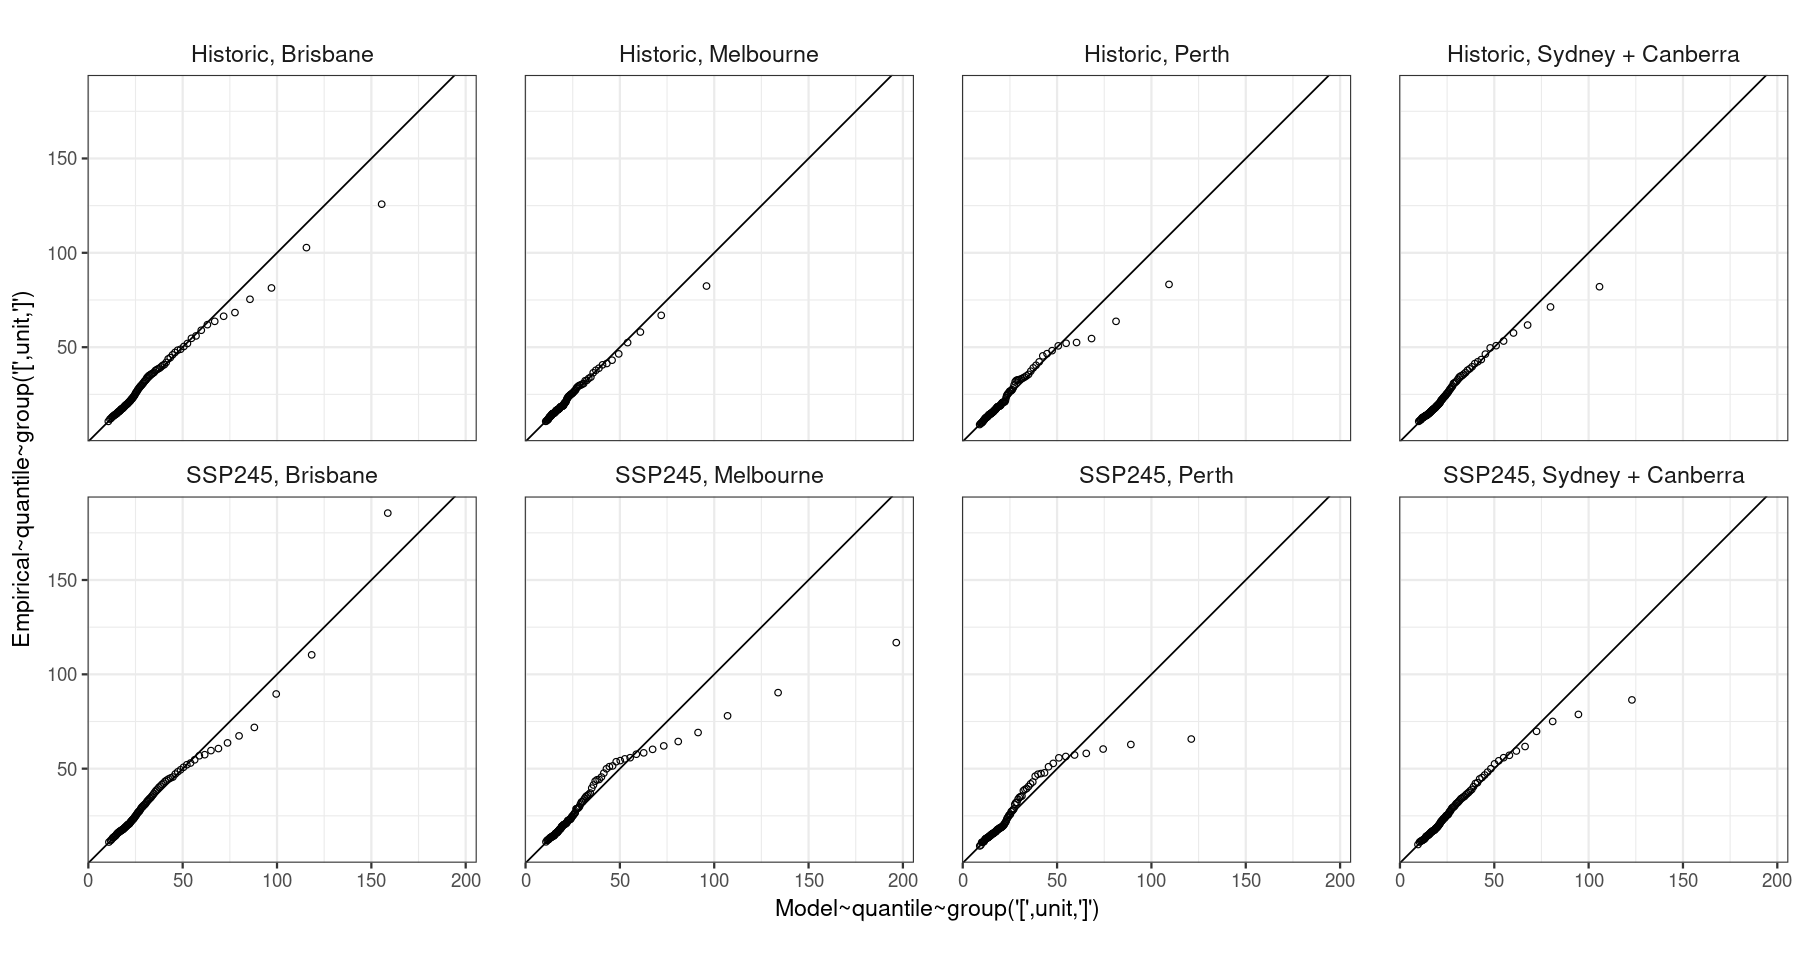

In [51]:
options(repr.plot.width = 15, repr.plot.height = 8)
plot_quantiles(gev_fits = gev_fits, var = "hailcast_diam_max", unit = "mm", file = "paper/figures/qq_hail.pdf")

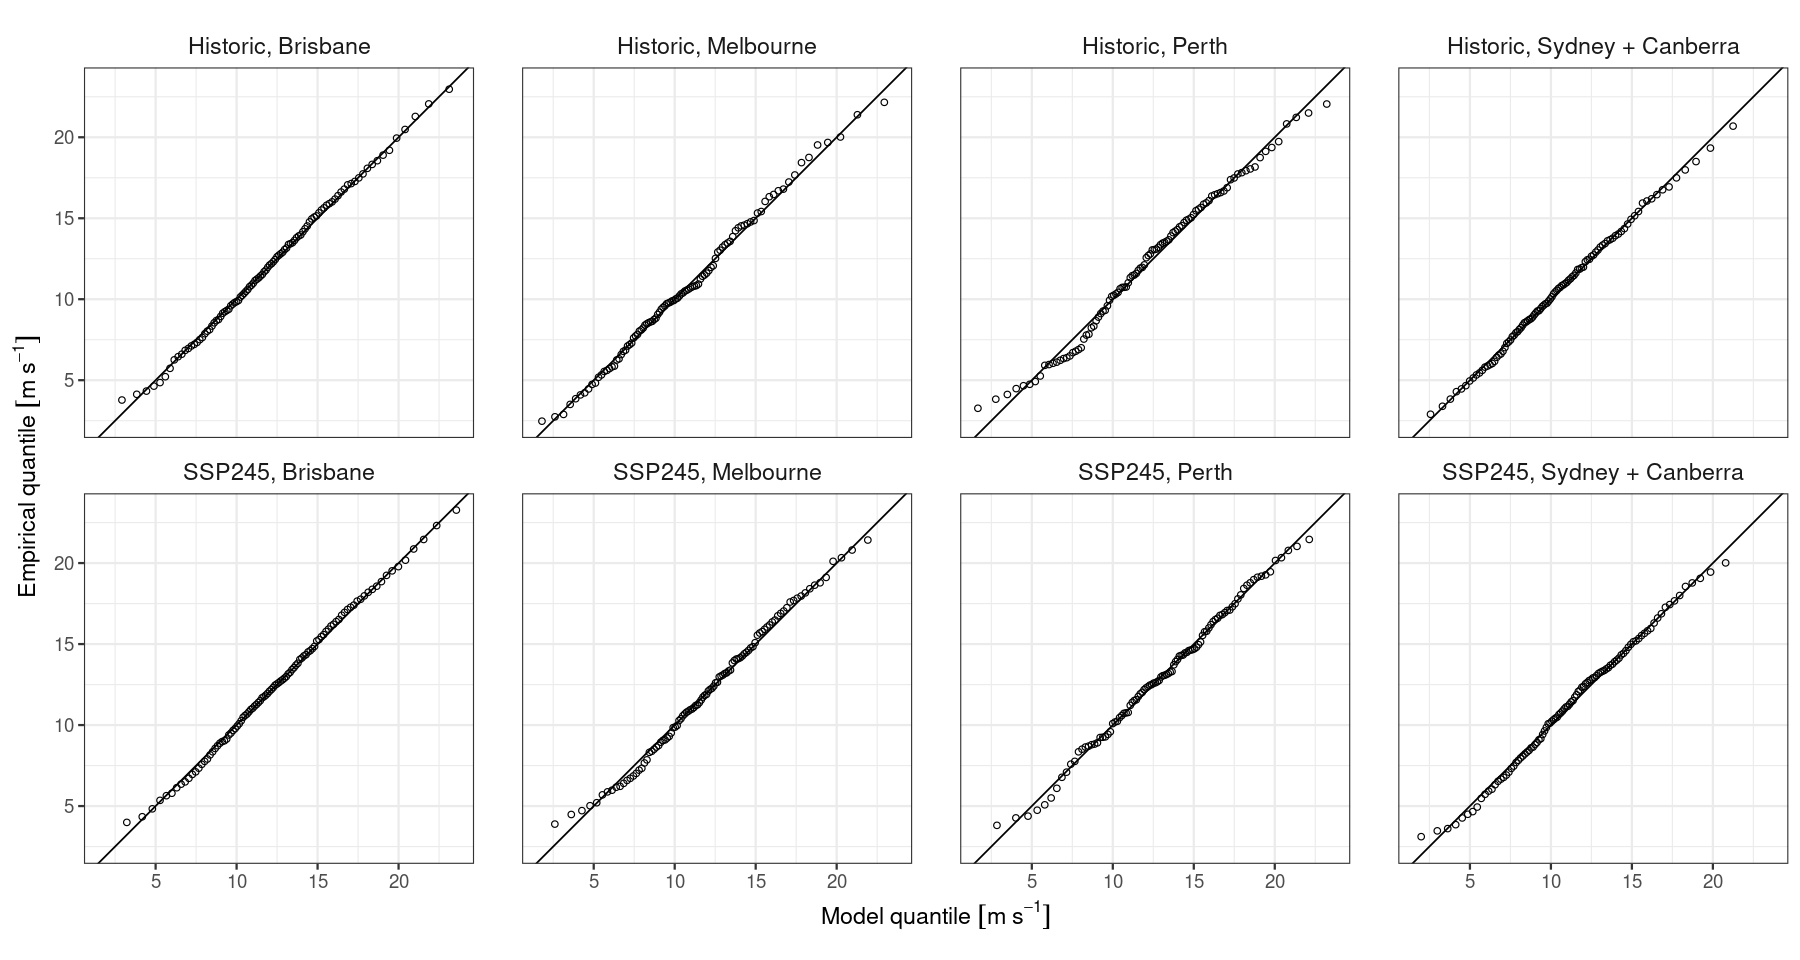

In [53]:
plot_quantiles(gev_fits = gev_fits, var = "wind_10m", unit = "m~s^{-1}", file = "paper/figures/qq_wind.pdf")

In [21]:
unit = "mm"
paste("Model quantile [", unit, "]")

[1] "Model quantile [ mm ]"

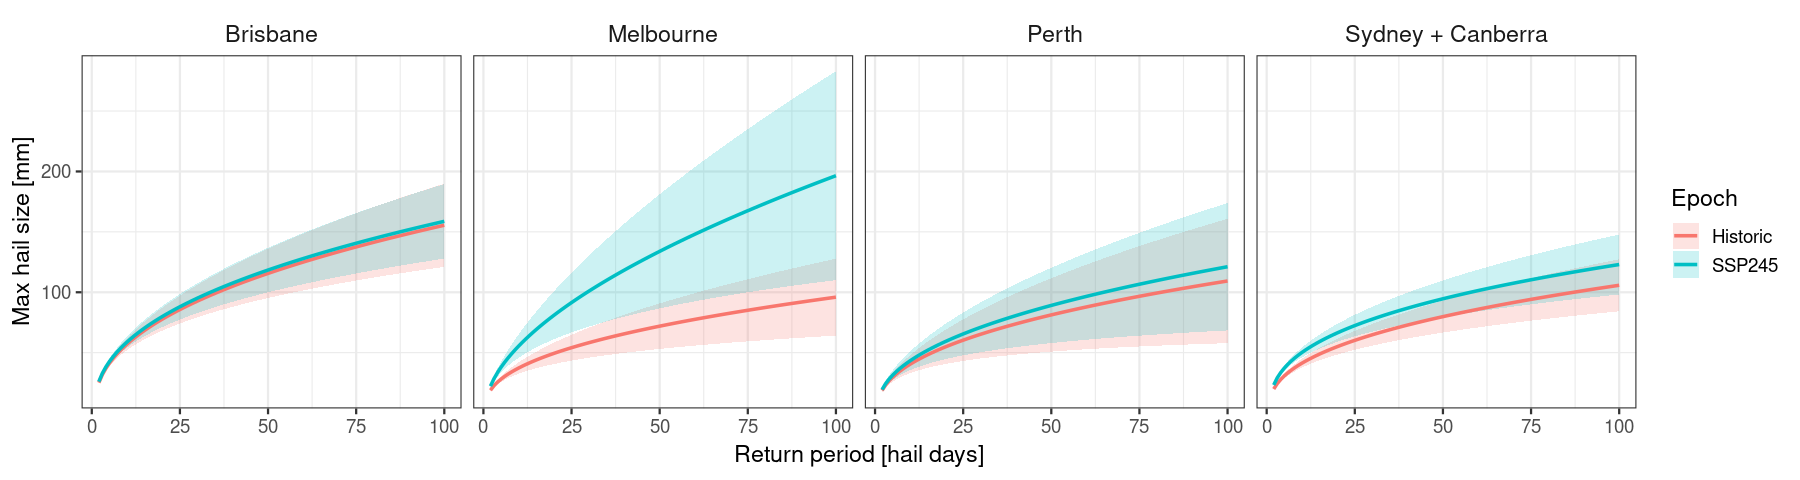

In [11]:
options(repr.plot.width = 15, repr.plot.height = 4)
plot_return_levels(gev_fits = gev_fits)

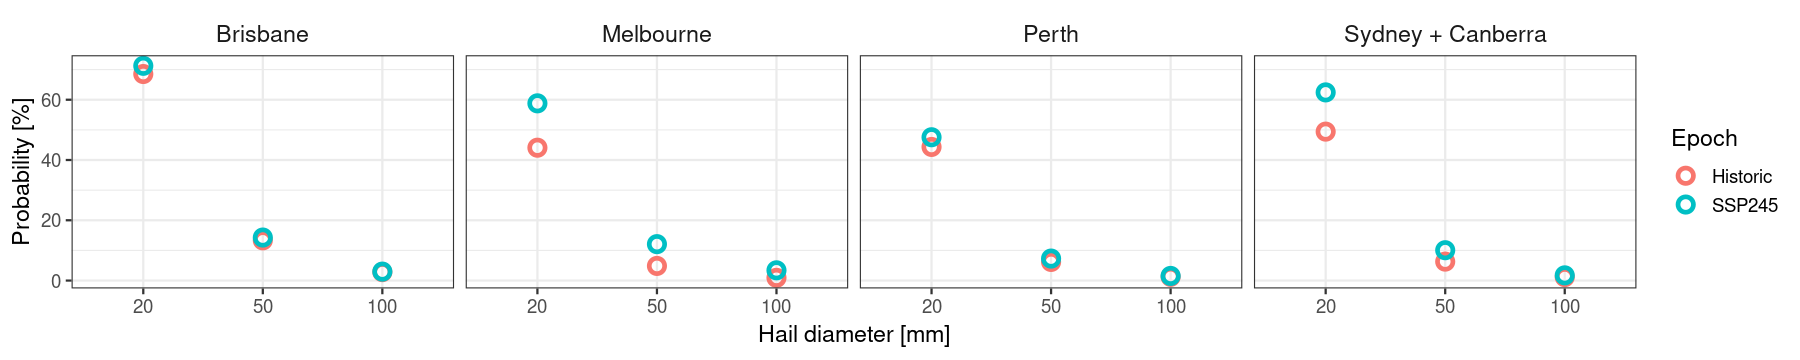

In [12]:
options(repr.plot.width = 15, repr.plot.height = 3)
plot_hail_probs(gev_fits = gev_fits)